In [1]:
pip install numPy pandas matplotlib seaborn scikit-learn jupyterlab


   ---------------------------------------- 0/2 [lark]
   ---------------------------------------- 2/2 [rfc3987-syntax]

Note: you may need to restart the kernel to use updated packages.


In [16]:
import pandas as pd
import os

# --- Load the PROCESSED (but not yet aggregated) pollutant data ---
POLLUTANTS_FILE = os.path.join("..", "data", "processed", "pollutants.csv")

try:
    df_poll_raw = pd.read_csv(POLLUTANTS_FILE, low_memory=False)
    print("✅ Raw pollutant data loaded successfully!")

    # --- Filter for India ---
    df_poll_india_raw = df_poll_raw[df_poll_raw['Country_Name'] == "India"].copy()

    # --- Check the IPCC Sector Codes Available for India ---
    sector_col = 'ipcc_code_2006_for_standard_report' # The column containing sector info

    if sector_col in df_poll_india_raw.columns:
        print(f"\n--- Unique Sector Codes ({sector_col}) for India ---")
        unique_sectors = df_poll_india_raw[sector_col].unique()
        print(unique_sectors)

        # Check if 'TOTALS' is actually present
        if 'TOTALS' in unique_sectors:
            print("\n✅ 'TOTALS' sector code IS present in the raw data for India.")
        else:
            print("\n⚠️ 'TOTALS' sector code IS NOT present for India.")
            print("   We need to manually sum the relevant sectors to get a total.")

    else:
        print(f"❌ Column '{sector_col}' not found in the pollutant data!")


except FileNotFoundError:
    print(f"❌ ERROR: File not found at {POLLUTANTS_FILE}")
except Exception as e:
    print(f"An error occurred: {e}")

✅ Raw pollutant data loaded successfully!

--- Unique Sector Codes (ipcc_code_2006_for_standard_report) for India ---
['1.A.1.a' '1.A.2' '1.A.3.b_noRES' '1.A.3.b_RES' '1.A.4' '1.B.1' '3.C.1'
 '1.A.1.bc' '1.A.3.a' '1.A.3.c' '1.A.3.d' '1.A.3.e' '1.A.5' '1.B.2'
 '2.A.1' '2.A.2' '2.A.3' '2.A.4' '2.B' '2.C' '2.H' '5.B' '2.D' '3.A.2'
 '3.C.4' '4.B' '4.C' '4.D' '2.G' '4.A' '3.C.2' '3.C.7']

⚠️ 'TOTALS' sector code IS NOT present for India.
   We need to manually sum the relevant sectors to get a total.


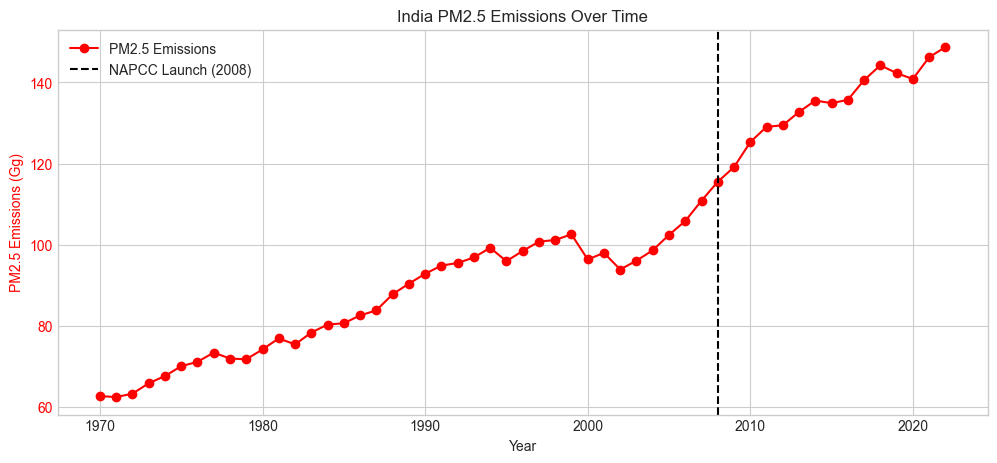

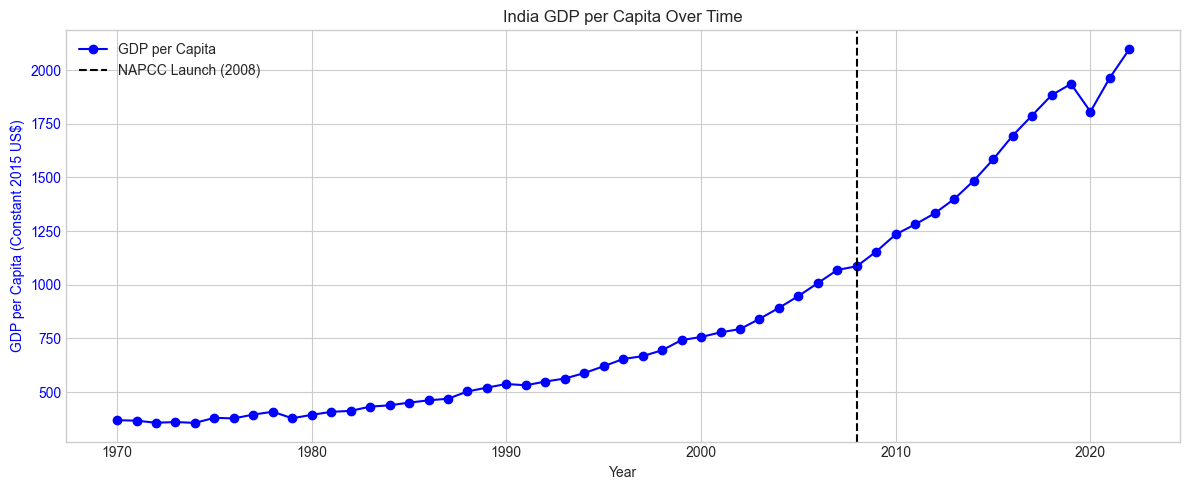

In [17]:
# --- Plotting Setup ---
# Make sure plots appear inline in the notebook
%matplotlib inline 
# Use a nice style
plt.style.use('seaborn-v0_8-whitegrid')

# --- Plot 1: PM2.5 Emissions ---
fig, ax1 = plt.subplots(figsize=(12, 5)) # Create a figure and one axes

# Plot PM2.5 data on the first axes
# NOTE: Your PM2.5 column name might be slightly different. Check df.columns if you get an error.
pm25_col = 'EDGAR_PM2' # Adjust if your column name is different
ax1.plot(df['Year'], df[pm25_col], label='PM2.5 Emissions', color='red', marker='o')
ax1.set_xlabel('Year')
ax1.set_ylabel('PM2.5 Emissions (Gg)', color='red')
ax1.tick_params(axis='y', labelcolor='red')
ax1.set_title('India PM2.5 Emissions Over Time')

# Add vertical line for the policy intervention
ax1.axvline(x=2008, color='black', linestyle='--', label='NAPCC Launch (2008)')
ax1.legend(loc='upper left')
ax1.grid(True)


# --- Plot 2: GDP per Capita ---
fig, ax2 = plt.subplots(figsize=(12, 5)) # Create a second figure

# Plot GDP data
gdp_col = 'GDP per capita (constant 2015 US$)'
ax2.plot(df['Year'], df[gdp_col], label='GDP per Capita', color='blue', marker='o')
ax2.set_xlabel('Year')
ax2.set_ylabel('GDP per Capita (Constant 2015 US$)', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.set_title('India GDP per Capita Over Time')

# Add vertical line for the policy intervention
ax2.axvline(x=2008, color='black', linestyle='--', label='NAPCC Launch (2008)')
ax2.legend(loc='upper left')
ax2.grid(True)

plt.tight_layout() # Adjust layout to prevent overlap
plt.show() # Display the plots

In [18]:
!pip install dowhy econml

In [19]:
# --- 1. Install DoWhy (if you haven't already) ---
# You might need to run this in your terminal: pip install dowhy
# Or uncomment and run this cell:
# !pip install dowhy econml

# --- 2. Prepare Data for DoWhy ---
print("--- Preparing data for DoWhy ---")

# Copy the dataframe to avoid changing the original
df_model = df.copy()

# Rename columns for easier use in DoWhy/EconML
# We need shorter names without spaces or special chars
df_model = df_model.rename(columns={
    'EDGAR_PM2': 'pm25_emissions', # Our outcome variable
    'policy_NAPCC_active': 'treatment', # Our policy variable
    'GDP per capita (constant 2015 US$)': 'confounder_gdp',
    'Industry (including construction), value added (% of GDP)': 'confounder_industry_pct',
    'Population, total': 'confounder_population',
    'Renewable energy consumption (% of total final energy consumption)': 'confounder_renewables_pct'
})

# Select only the columns needed for the model
# (Add other pollutants later if you want to test them)
cols_for_model = [
    'Year',
    'pm25_emissions',
    'treatment',
    'confounder_gdp',
    'confounder_industry_pct',
    'confounder_population',
    'confounder_renewables_pct'
]
df_model = df_model[cols_for_model]

# --- 3. Handle Missing Data (Simple Forward Fill) ---
# The 'Renewable energy...' column had many NaNs.
# Forward fill propagates the last valid observation forward.
# We should ideally use a more sophisticated method later (like interpolation).
missing_before = df_model.isnull().sum().sum()
df_model = df_model.ffill()
missing_after = df_model.isnull().sum().sum()

# If there were still NaNs at the beginning, backfill them
if missing_after > 0:
    df_model = df_model.bfill()
    missing_after = df_model.isnull().sum().sum()

print(f"Handled missing values. Missing count before: {missing_before}, after: {missing_after}")

print("\n--- Cleaned DataFrame for Model ---")
print(df_model.head())
print("\n--- Data Types ---")
print(df_model.info()) # Check that all columns are numeric

--- Preparing data for DoWhy ---
Handled missing values. Missing count before: 21, after: 0

--- Cleaned DataFrame for Model ---
   Year  pm25_emissions  treatment  confounder_gdp  confounder_industry_pct  \
0  1970       62.735335          0      369.192481                21.729309   
1  1971       62.488069          0      367.033310                22.392008   
2  1972       63.332115          0      357.077929                22.408003   
3  1973       65.885815          0      360.637844                21.348230   
4  1974       67.683233          0      356.615070                22.675693   

   confounder_population  confounder_renewables_pct  
0            545864268.0                       53.0  
1            558096387.0                       53.0  
2            570482142.0                       53.0  
3            583465598.0                       53.0  
4            597041391.0                       53.0  

--- Data Types ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53

In [18]:
!pip install pygraphviz logging dowhy econml

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
Failed to build pygraphviz


  error: subprocess-exited-with-error
  
  × Building wheel for pygraphviz (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [94 lines of output]
      C:\Users\Admin\AppData\Local\Temp\pip-build-env-1mg_9a1f\overlay\Lib\site-packages\setuptools\config\_apply_pyprojecttoml.py:82: SetuptoolsDeprecationWarning: `project.license` as a TOML table is deprecated
      !!
      
              ********************************************************************************
              Please use a simple string containing a SPDX expression for `project.license`. You can also use `project.license-files`. (Both options available on setuptools>=77.0.0).
      
              By 2026-Feb-18, you need to update your project and remove deprecated calls
              or your builds will no longer be supported.
      
              See https://packaging.python.org/en/latest/guides/writing-pyproject-toml/#license for details.
              **********************************************

In [20]:
pip install pydot

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: pydot in c:\users\admin\appdata\local\programs\python\python310\lib\site-packages (4.0.1)




[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
from dowhy import CausalModel
import logging
# Optional: Suppress excessive logging from DoWhy/EconML if needed
# logging.getLogger("dowhy").setLevel(logging.WARNING)

# --- Define Model Components Directly ---
common_causes = [
    'confounder_gdp',
    'confounder_industry_pct',
    'confounder_population',
    'confounder_renewables_pct',
    'Year' # Include Year directly as a common cause
]

print("--- Step 1: Defining Causal Model (using common_causes) ---")
# Instead of passing the graph string, we pass the list of confounders
model = CausalModel(
    data=df_model,
    treatment='treatment',
    outcome='pm25_emissions',
    common_causes=common_causes # Directly specify confounders
)

# --- Skip Graph Visualization ---
print("Skipping graph visualization due to dependency issues.")


# --- 2. Identify the Causal Effect ---
# DoWhy finds a valid statistical method based on the common causes.
print("\n--- Step 2: Identifying Causal Estimand ---")
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)


# --- 3. Estimate the Causal Effect (ATE) ---
# We'll use linear regression as a simple baseline estimator.
print("\n--- Step 3: Estimating the Average Treatment Effect (ATE) ---")
estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.linear_regression",
    test_significance=True # Adds statistical significance test
)

print("\n--- Causal Estimate ---")
print(estimate)
print(f"\nEstimated Causal Effect (ATE): {estimate.value:.3f}")


# --- 4. Refute the Estimate ---
# Placebo Treatment: Randomly assigns the treatment dates. Should find near-zero effect.
print("\n--- Step 4: Refuting the Estimate (Placebo Test) ---")
refute_placebo = model.refute_estimate(
    identified_estimand,
    estimate,
    method_name="placebo_treatment_refuter",
    placebo_type="permute", # Randomly shuffle treatment assignment
    num_simulations=100 # Run 100 random shuffles
)

print("\n--- Placebo Refutation Results ---")
print(refute_placebo)

--- Step 1: Defining Causal Model (using common_causes) ---
Skipping graph visualization due to dependency issues.

--- Step 2: Identifying Causal Estimand ---
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                                                                                                   ↪
────────────(E[pm_25_emissions|confounder_population,confounder_gdp,confounder_renewables_pct,confounder_industry_pct,Ye ↪
d[treatment]                                                                                                             ↪

↪     
↪ ar])
↪     
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→pm25_emissions then P(pm25_emissions|treatment,confounder_population,confounder_gdp,confounder_renewables_pct,confounder_industry_pct,Year,U) = P(pm25_emissions|treatment,confounder_population,confounder_gdp,confounder_renewables_pct,confounder_industry_pct,Year)

### Estiman

D:\Installed\python3.12\Lib\site-packages\dowhy\causal_estimators\regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
D:\Installed\python3.12\Lib\site-packages\dowhy\causal_estimators\regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
D:\Installed\python3.12\Lib\site-packages\dowhy\causal_estimators\regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with D


--- Placebo Refutation Results ---
Refute: Use a Placebo Treatment
Estimated effect:11.772897842043648
New effect:-0.031369328609723086
p value:1.0



D:\Installed\python3.12\Lib\site-packages\dowhy\causal_estimators\regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
D:\Installed\python3.12\Lib\site-packages\dowhy\causal_estimators\regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
D:\Installed\python3.12\Lib\site-packages\dowhy\causal_estimators\regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with D

In [20]:
# --- 3b. Estimate using Propensity Score Weighting ---
print("\n--- Step 3b: Estimating ATE using Propensity Score Weighting ---")

# This method first models the probability of treatment based on confounders
# then weights the data to create balanced groups before comparing outcomes.
estimate_psw = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.propensity_score_weighting",
    target_units="ate",  # Average Treatment Effect
    method_params={"weighting_scheme": "ips_weight"} # Use standard inverse propensity score weighting
)

print("\n--- Causal Estimate (Propensity Score Weighting) ---")
print(estimate_psw)
print(f"\nEstimated Causal Effect (ATE) using PSW: {estimate_psw.value:.3f}")


# --- 4b. Refute the PSW Estimate (Placebo Test) ---
# We should always refute our chosen estimate
print("\n--- Step 4b: Refuting the PSW Estimate (Placebo Test) ---")
refute_placebo_psw = model.refute_estimate(
    identified_estimand,
    estimate_psw, # Refute the new estimate
    method_name="placebo_treatment_refuter",
    placebo_type="permute",
    num_simulations=100
)

print("\n--- Placebo Refutation Results (PSW) ---")
print(refute_placebo_psw)


--- Step 3b: Estimating ATE using Propensity Score Weighting ---

--- Causal Estimate (Propensity Score Weighting) ---
*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                                                                                                      
────────────(E[pm_25_emissions|confounder_population,confounder_gdp,Year,confounder_industry_pct,confounder_renewables_pct])
d[treatment]                                                                                                                
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→pm25_emissions then P(pm25_emissions|treatment,confounder_population,confounder_gdp,Year,confounder_industry_pct,confounder_renewables_pct,U) = P(pm25_emissions|treatment,confounder_population,confounder_gdp,Year,confounder_industry_pct,confounder_renewables_pct)

## Realized estiman

In [21]:
# --- 3b. Estimate using Propensity Score Weighting ---
print("\n--- Step 3b: Estimating ATE using Propensity Score Weighting ---")

try:
    # This method first models the probability of treatment based on confounders
    # then weights the data to create balanced groups before comparing outcomes.
    estimate_psw = model.estimate_effect(
        identified_estimand,
        method_name="backdoor.propensity_score_weighting",
        target_units="ate",  # Average Treatment Effect
        method_params={"weighting_scheme": "ips_weight"} # Use standard inverse propensity score weighting
    )

    print("\n--- Causal Estimate (Propensity Score Weighting) ---")
    print(estimate_psw)
    print(f"\nEstimated Causal Effect (ATE) using PSW: {estimate_psw.value:.3f}")

    # --- 4b. Refute the PSW Estimate (Placebo Test) ---
    print("\n--- Step 4b: Refuting the PSW Estimate (Placebo Test) ---")
    refute_placebo_psw = model.refute_estimate(
        identified_estimand,
        estimate_psw, # Refute the new estimate
        method_name="placebo_treatment_refuter",
        placebo_type="permute",
        num_simulations=100
    )

    print("\n--- Placebo Refutation Results (PSW) ---")
    print(refute_placebo_psw)

except Exception as e:
    print(f"\n❌ An error occurred during Propensity Score Weighting or Refutation: {e}")
    print("   This can sometimes happen if propensity scores are too close to 0 or 1.")
    print("   Consider trying 'propensity_score_matching' or checking confounder overlap.")


--- Step 3b: Estimating ATE using Propensity Score Weighting ---

--- Causal Estimate (Propensity Score Weighting) ---
*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                                                                                                      
────────────(E[pm_25_emissions|confounder_population,confounder_gdp,Year,confounder_industry_pct,confounder_renewables_pct])
d[treatment]                                                                                                                
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→pm25_emissions then P(pm25_emissions|treatment,confounder_population,confounder_gdp,Year,confounder_industry_pct,confounder_renewables_pct,U) = P(pm25_emissions|treatment,confounder_population,confounder_gdp,Year,confounder_industry_pct,confounder_renewables_pct)

## Realized estiman

In [22]:
# --- 3c. Estimate using Propensity Score Matching ---
print("\n--- Step 3c: Estimating ATE using Propensity Score Matching ---")

try:
    # Matching tries to find pairs of treated and untreated units
    # with similar confounder values (similar propensity scores).
    estimate_psm = model.estimate_effect(
        identified_estimand,
        method_name="backdoor.propensity_score_matching",
        target_units="ate",
        method_params={'match_on_covariates': True} # Match directly on confounders
    )

    print("\n--- Causal Estimate (Propensity Score Matching) ---")
    print(estimate_psm)
    print(f"\nEstimated Causal Effect (ATE) using PSM: {estimate_psm.value:.3f}")

    # --- 4c. Refute the PSM Estimate (Placebo Test) ---
    print("\n--- Step 4c: Refuting the PSM Estimate (Placebo Test) ---")
    refute_placebo_psm = model.refute_estimate(
        identified_estimand,
        estimate_psm, # Refute the new estimate
        method_name="placebo_treatment_refuter",
        placebo_type="permute",
        num_simulations=100
    )

    print("\n--- Placebo Refutation Results (PSM) ---")
    print(refute_placebo_psm)

except Exception as e:
    print(f"\n❌ An error occurred during Propensity Score Matching or Refutation: {e}")
    print("   Consider checking confounder distributions or trying different matching parameters.")


--- Step 3c: Estimating ATE using Propensity Score Matching ---

--- Causal Estimate (Propensity Score Matching) ---
*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                                                                                                      
────────────(E[pm_25_emissions|confounder_population,confounder_gdp,Year,confounder_industry_pct,confounder_renewables_pct])
d[treatment]                                                                                                                
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→pm25_emissions then P(pm25_emissions|treatment,confounder_population,confounder_gdp,Year,confounder_industry_pct,confounder_renewables_pct,U) = P(pm25_emissions|treatment,confounder_population,confounder_gdp,Year,confounder_industry_pct,confounder_renewables_pct)

## Realized estimand


In [23]:
# --- 4d. Refute Linear Regression Estimate (Random Common Cause) ---
print("\n--- Step 4d: Refuting Linear Regression Estimate (Random Common Cause) ---")

# This test adds a fake random confounder to see if the estimate is sensitive
# If the estimate changes drastically, it might be fragile to unobserved confounders
refute_random_cause = model.refute_estimate(
    identified_estimand,
    estimate, # Use the original linear regression estimate
    method_name="random_common_cause",
    num_simulations=100
)

print("\n--- Random Common Cause Refutation Results ---")
print(refute_random_cause)


--- Step 4d: Refuting Linear Regression Estimate (Random Common Cause) ---


D:\Installed\MiniConda\envs\ai_env\Lib\site-packages\dowhy\causal_estimators\regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
D:\Installed\MiniConda\envs\ai_env\Lib\site-packages\dowhy\causal_estimators\regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
D:\Installed\MiniConda\envs\ai_env\Lib\site-packages\dowhy\causal_estimators\regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be tre


--- Random Common Cause Refutation Results ---
Refute: Add a random common cause
Estimated effect:11.772897842043065
New effect:11.64866031477688
p value:0.82



D:\Installed\MiniConda\envs\ai_env\Lib\site-packages\dowhy\causal_estimators\regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
D:\Installed\MiniConda\envs\ai_env\Lib\site-packages\dowhy\causal_estimators\regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
D:\Installed\MiniConda\envs\ai_env\Lib\site-packages\dowhy\causal_estimators\regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be tre

In [24]:
print("--- Testing for Lagged Policy Effects ---")

# Use the cleaned df_model from the previous step
df_lagged = df_model.copy()

# Define the policy start year
POLICY_START_YEAR = 2008
INITIAL_EFFECT_YEARS = 5 # Test effect for first 5 years (2008-2012)

# Create lagged treatment variables
df_lagged['treatment_initial'] = ((df_lagged['Year'] >= POLICY_START_YEAR) &
                                  (df_lagged['Year'] < POLICY_START_YEAR + INITIAL_EFFECT_YEARS)).astype(int)

df_lagged['treatment_later'] = (df_lagged['Year'] >= POLICY_START_YEAR + INITIAL_EFFECT_YEARS).astype(int)

# --- Re-run Linear Regression with Lagged Treatments ---
# We need to tell DoWhy about BOTH treatment variables now.
# This requires a slightly different approach using statsmodels directly
# (as DoWhy's simple interface assumes one treatment variable).

import statsmodels.formula.api as smf

# Define the confounders as strings for the formula
confounder_str = " + ".join([
    'confounder_gdp',
    'confounder_industry_pct',
    'confounder_population',
    'confounder_renewables_pct',
    'Year' # Still control for the time trend
])

# Build the regression formula including BOTH treatment lags
# We exclude the original 'treatment' column now
formula = f"pm25_emissions ~ treatment_initial + treatment_later + {confounder_str}"

print(f"\nRunning regression model:\n {formula}")

# Fit the Ordinary Least Squares (OLS) model
ols_model = smf.ols(formula, data=df_lagged).fit()

# --- Print the Results ---
print("\n--- Regression Results with Lagged Effects ---")
print(ols_model.summary())

# Extract coefficients and p-values for the treatment variables
ate_initial = ols_model.params['treatment_initial']
p_initial = ols_model.pvalues['treatment_initial']
ate_later = ols_model.params['treatment_later']
p_later = ols_model.pvalues['treatment_later']

print("\n--- Estimated Lagged Effects ---")
print(f"Effect during initial {INITIAL_EFFECT_YEARS} years (2008-{POLICY_START_YEAR + INITIAL_EFFECT_YEARS - 1}): {ate_initial:.3f} (p={p_initial:.4f})")
print(f"Effect after {INITIAL_EFFECT_YEARS} years ({POLICY_START_YEAR + INITIAL_EFFECT_YEARS} onwards): {ate_later:.3f} (p={p_later:.4f})")

--- Testing for Lagged Policy Effects ---

Running regression model:
 pm25_emissions ~ treatment_initial + treatment_later + confounder_gdp + confounder_industry_pct + confounder_population + confounder_renewables_pct + Year

--- Regression Results with Lagged Effects ---
                            OLS Regression Results                            
Dep. Variable:         pm25_emissions   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.983
Method:                 Least Squares   F-statistic:                     420.9
Date:                Wed, 29 Oct 2025   Prob (F-statistic):           8.21e-39
Time:                        00:40:52   Log-Likelihood:                -135.18
No. Observations:                  53   AIC:                             286.4
Df Residuals:                      45   BIC:                             302.1
Df Model:                           7                                         
Covariance Type:

In [25]:
# --- Refute Original Linear Regression Estimate (Random Common Cause) ---
print("\n--- Refuting Original Linear Regression Estimate (Random Common Cause) ---")

# This test adds a fake random confounder to see if the estimate is sensitive
# If the estimate changes drastically, it might be fragile to unobserved confounders

# We need the original 'model' and 'estimate' objects from the first analysis
# Make sure the cell where you ran the first CausalModel estimate has been run

try:
    refute_random_cause = model.refute_estimate(
        identified_estimand, # From the first model identification
        estimate,          # The original linear regression estimate object
        method_name="random_common_cause",
        num_simulations=100
    )
    print("\n--- Random Common Cause Refutation Results ---")
    print(refute_random_cause)
except NameError:
    print("\n❌ ERROR: 'model' or 'estimate' object not found.")
    print("   Please re-run the cell containing the first CausalModel estimation.")
except Exception as e:
     print(f"\n❌ An error occurred during refutation: {e}")


--- Refuting Original Linear Regression Estimate (Random Common Cause) ---


D:\Installed\MiniConda\envs\ai_env\Lib\site-packages\dowhy\causal_estimators\regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
D:\Installed\MiniConda\envs\ai_env\Lib\site-packages\dowhy\causal_estimators\regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
D:\Installed\MiniConda\envs\ai_env\Lib\site-packages\dowhy\causal_estimators\regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be tre


--- Random Common Cause Refutation Results ---
Refute: Add a random common cause
Estimated effect:11.772897842043065
New effect:11.822469051747595
p value:0.8



D:\Installed\MiniConda\envs\ai_env\Lib\site-packages\dowhy\causal_estimators\regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
D:\Installed\MiniConda\envs\ai_env\Lib\site-packages\dowhy\causal_estimators\regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
D:\Installed\MiniConda\envs\ai_env\Lib\site-packages\dowhy\causal_estimators\regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be tre